# Example `Dysmalpy` model

**Includes the following components:**

 - Disk + Bulge
 - NFW halo
 - Constant velocity dispersion

## Setup steps ##

**Import modules**

In [1]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

from dysmalpy import galaxy
from dysmalpy import models
from dysmalpy import instrument
from dysmalpy import data_classes
from dysmalpy import parameters
from dysmalpy import plotting

import numpy as np
import astropy.units as u
import astropy.io.fits as fits

**Setup notebook**

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
mpl.rcParams['figure.dpi']= 300
mpl.rc("savefig", dpi=300)

-----------

**Set function to tie scale height relative to effective radius**

In [4]:
def tie_sigz_reff(model_set):
 
    reff = model_set.components['disk+bulge'].r_eff_disk.value
    invq = model_set.components['disk+bulge'].invq_disk
    sigz = 2.0*reff/invq/2.35482

    return sigz

---------

## Initialize galaxy, model set, instrument

In [5]:
gal = galaxy.Galaxy(z=2., name='galaxy')
mod_set = models.ModelSet()
inst = instrument.Instrument()

### Baryonic component: Combined Disk+Bulge

In [6]:
total_mass = 10.5    # M_sun
bt = 0.3             # Bulge-Total ratio
r_eff_disk = 4.0     # kpc
n_disk = 1.0
invq_disk = 5.0
r_eff_bulge = 1.0    # kpc
n_bulge = 4.0
invq_bulge = 1.0
noord_flat = True    # Switch for applying Noordermeer flattening

# Fix components
bary_fixed = {'total_mass': False,
              'r_eff_disk': False,
              'n_disk': True,
              'r_eff_bulge': True,
              'n_bulge': True,
              'bt': False}

# Set bounds
bary_bounds = {'total_mass': (10, 13),
               'r_eff_disk': (1.0, 30.0),
               'n_disk': (1, 8),
               'r_eff_bulge': (1, 5),
               'n_bulge': (1, 8),
               'bt': (0, 1)}

bary = models.DiskBulge(total_mass=total_mass, bt=bt,
                        r_eff_disk=r_eff_disk, n_disk=n_disk,
                        invq_disk=invq_disk,
                        r_eff_bulge=r_eff_bulge, n_bulge=n_bulge,
                        invq_bulge=invq_bulge,
                        noord_flat=noord_flat,
                        name='disk+bulge',
                        fixed=bary_fixed, bounds=bary_bounds)

bary.r_eff_disk.prior = parameters.BoundedGaussianPrior(center=5.0, stddev=1.0)

### Halo component

In [7]:
mvirial = 12.0
conc = 5.0

halo_fixed = {'mvirial': False,
              'conc': True}

halo_bounds = {'mvirial': (10, 13),
               'conc': (1, 20)}

halo = models.NFW(mvirial=mvirial, conc=conc, z=gal.z,
                  fixed=halo_fixed, bounds=halo_bounds, name='halo')

halo.mvirial.prior = parameters.BoundedGaussianPrior(center=11.5, stddev=0.5)

### Dispersion profile

In [8]:
sigma0 = 39.   # km/s
disp_fixed = {'sigma0': False}
disp_bounds = {'sigma0': (5, 300)}

disp_prof = models.DispersionConst(sigma0=sigma0, fixed=disp_fixed,
                                          bounds=disp_bounds, name='dispprof')

### z-height profile

In [9]:
sigmaz = 0.9   # kpc
zheight_fixed = {'sigmaz': False}

zheight_prof = models.ZHeightGauss(sigmaz=sigmaz, name='zheightgaus',
                                   fixed=zheight_fixed)
zheight_prof.sigmaz.tied = tie_sigz_reff

### Geometry

In [10]:
inc = 62.     # degrees
pa = 142.     # degrees, blue-shifted side CCW from north
xshift = 0    # pixels from center
yshift = 0    # pixels from center

geom_fixed = {'inc': False,
              'pa': True,
              'xshift': True,
              'yshift': True}

geom_bounds = {'inc': (0, 90),
               'pa': (90, 180),
               'xshift': (0, 4),
               'yshift': (-10, -4)}

geom = models.Geometry(inc=inc, pa=pa, xshift=xshift, yshift=yshift,
                       fixed=geom_fixed, bounds=geom_bounds, name='geom')

### Add all model components to ModelSet

In [11]:
mod_set.add_component(bary, light=True)
mod_set.add_component(halo)
mod_set.add_component(disp_prof)
mod_set.add_component(zheight_prof)
mod_set.add_component(geom)

### Set kinematic options for calculating velocity profile

In [12]:
mod_set.kinematic_options.adiabatic_contract = False
mod_set.kinematic_options.pressure_support = True

### Set up the instrument

In [13]:
beamsize = 0.55*u.arcsec                 # FWHM of beam
sig_inst = 45*u.km/u.s                   # Instrumental spectral resolution

beam = instrument.GaussianBeam(major=beamsize)
lsf = instrument.LSF(sig_inst)

inst.beam = beam
inst.lsf = lsf
inst.pixscale = 0.125*u.arcsec           # arcsec/pixel
inst.fov = [33, 33]                      # (nx, ny) pixels
inst.spec_type = 'velocity'              # 'velocity' or 'wavelength'
inst.spec_step = 10*u.km/u.s             # Spectral step
inst.spec_start = -1000*u.km/u.s         # Starting value of spectrum
inst.nspec = 201                         # Number of spectral pixels

# Set the beam kernel so it doesn't have to be calculated every step
inst.set_beam_kernel()
inst.set_lsf_kernel()

### Add the model set, instrument to the Galaxy

In [14]:
gal.model = mod_set
gal.instrument = inst

## Create models

### 2D model

In [15]:
gal.create_model_data(oversample=3, ndim_final=2, from_data=False)

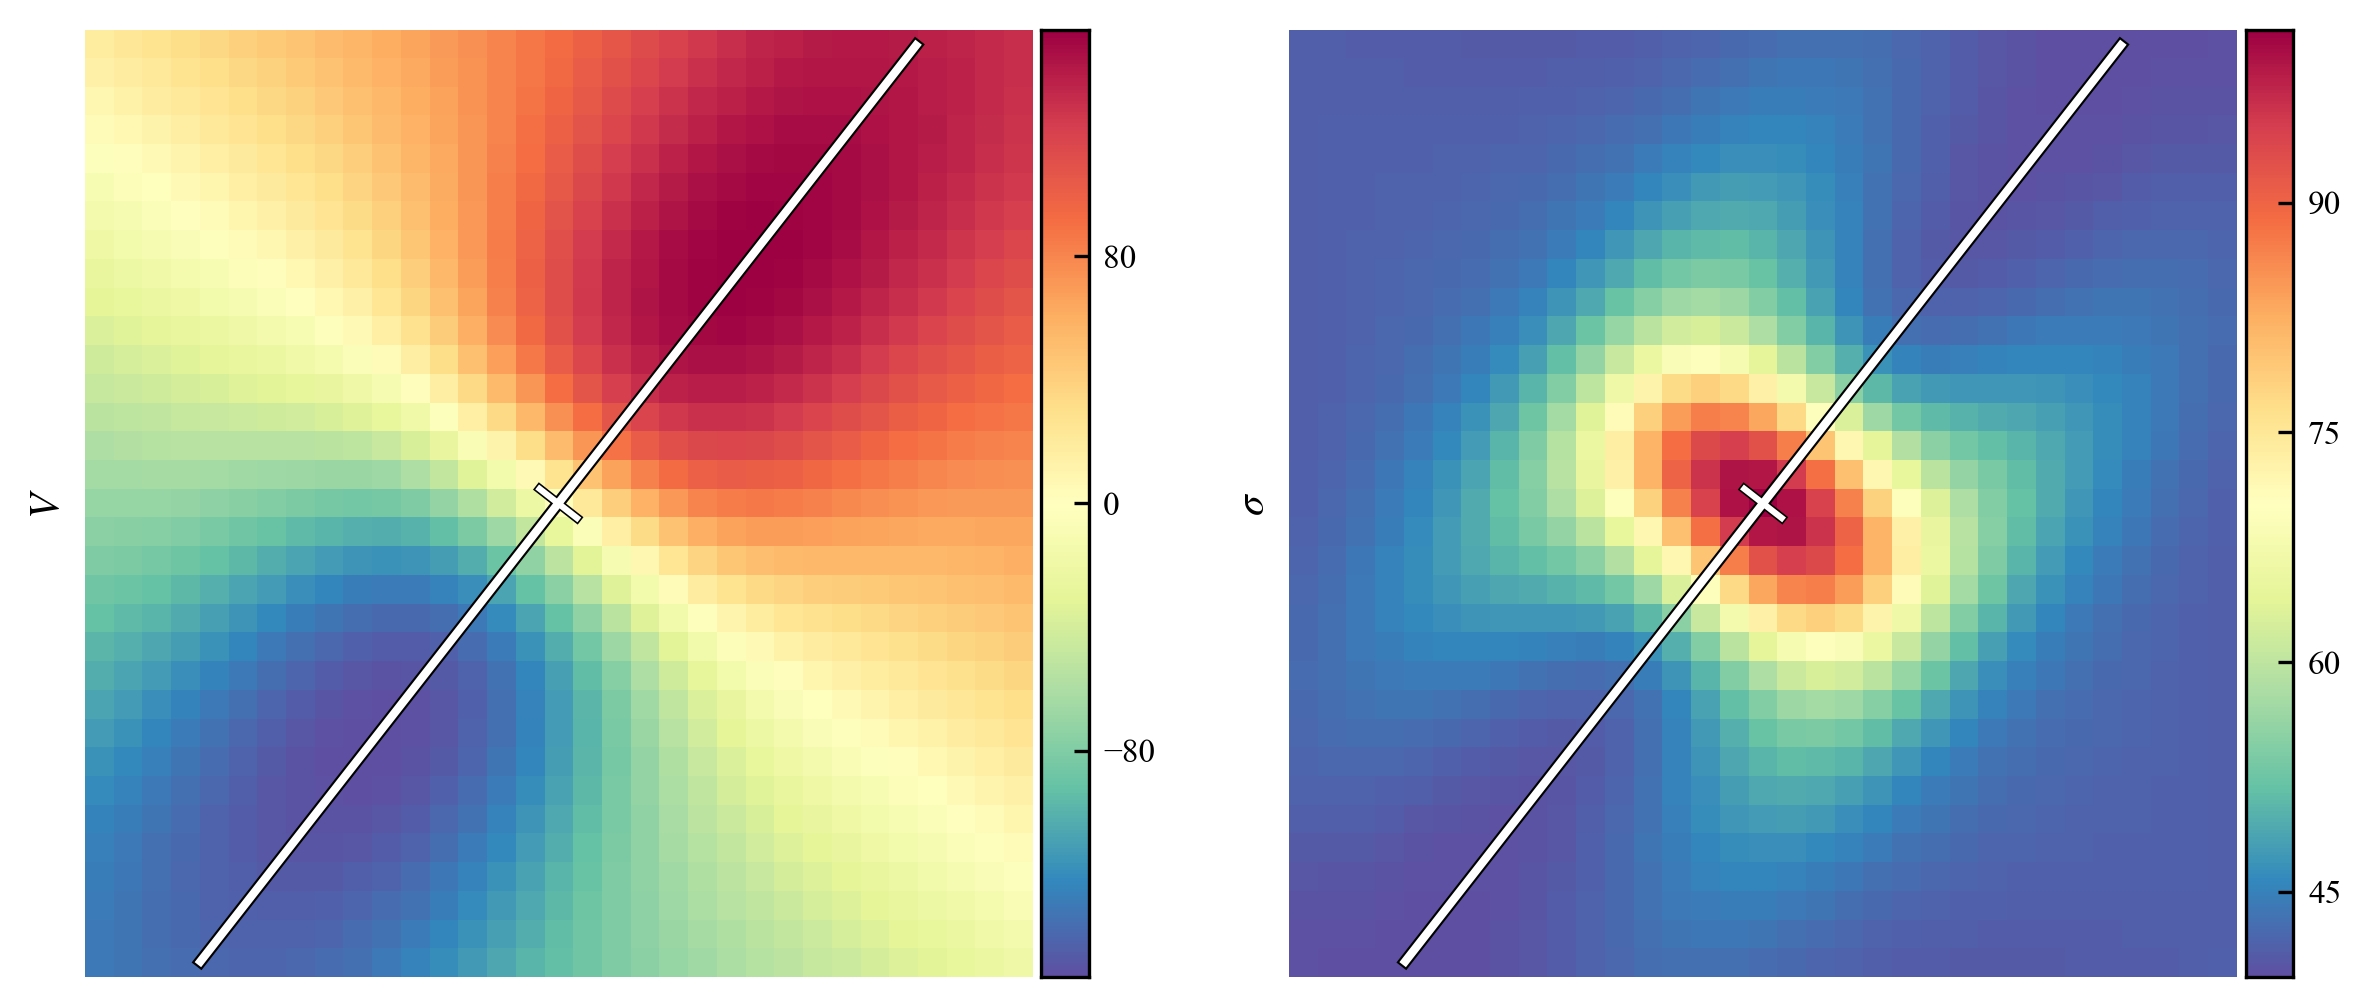

In [16]:
plotting.plot_model_2D(gal, inst_corr=True)

### 1D model

In [17]:
aper_arr = np.linspace(-(inst.fov[0]-1)/2., (inst.fov[0]-1)/2., 
                           num=inst.fov[0])*inst.pixscale.value
gal.create_model_data(oversample=3, ndim_final=1, from_data=False, 
                            slit_width = 0.55, slit_pa=142., 
                            aper_centers=aper_arr, 
                     profile1d_type='circ_ap_cube')

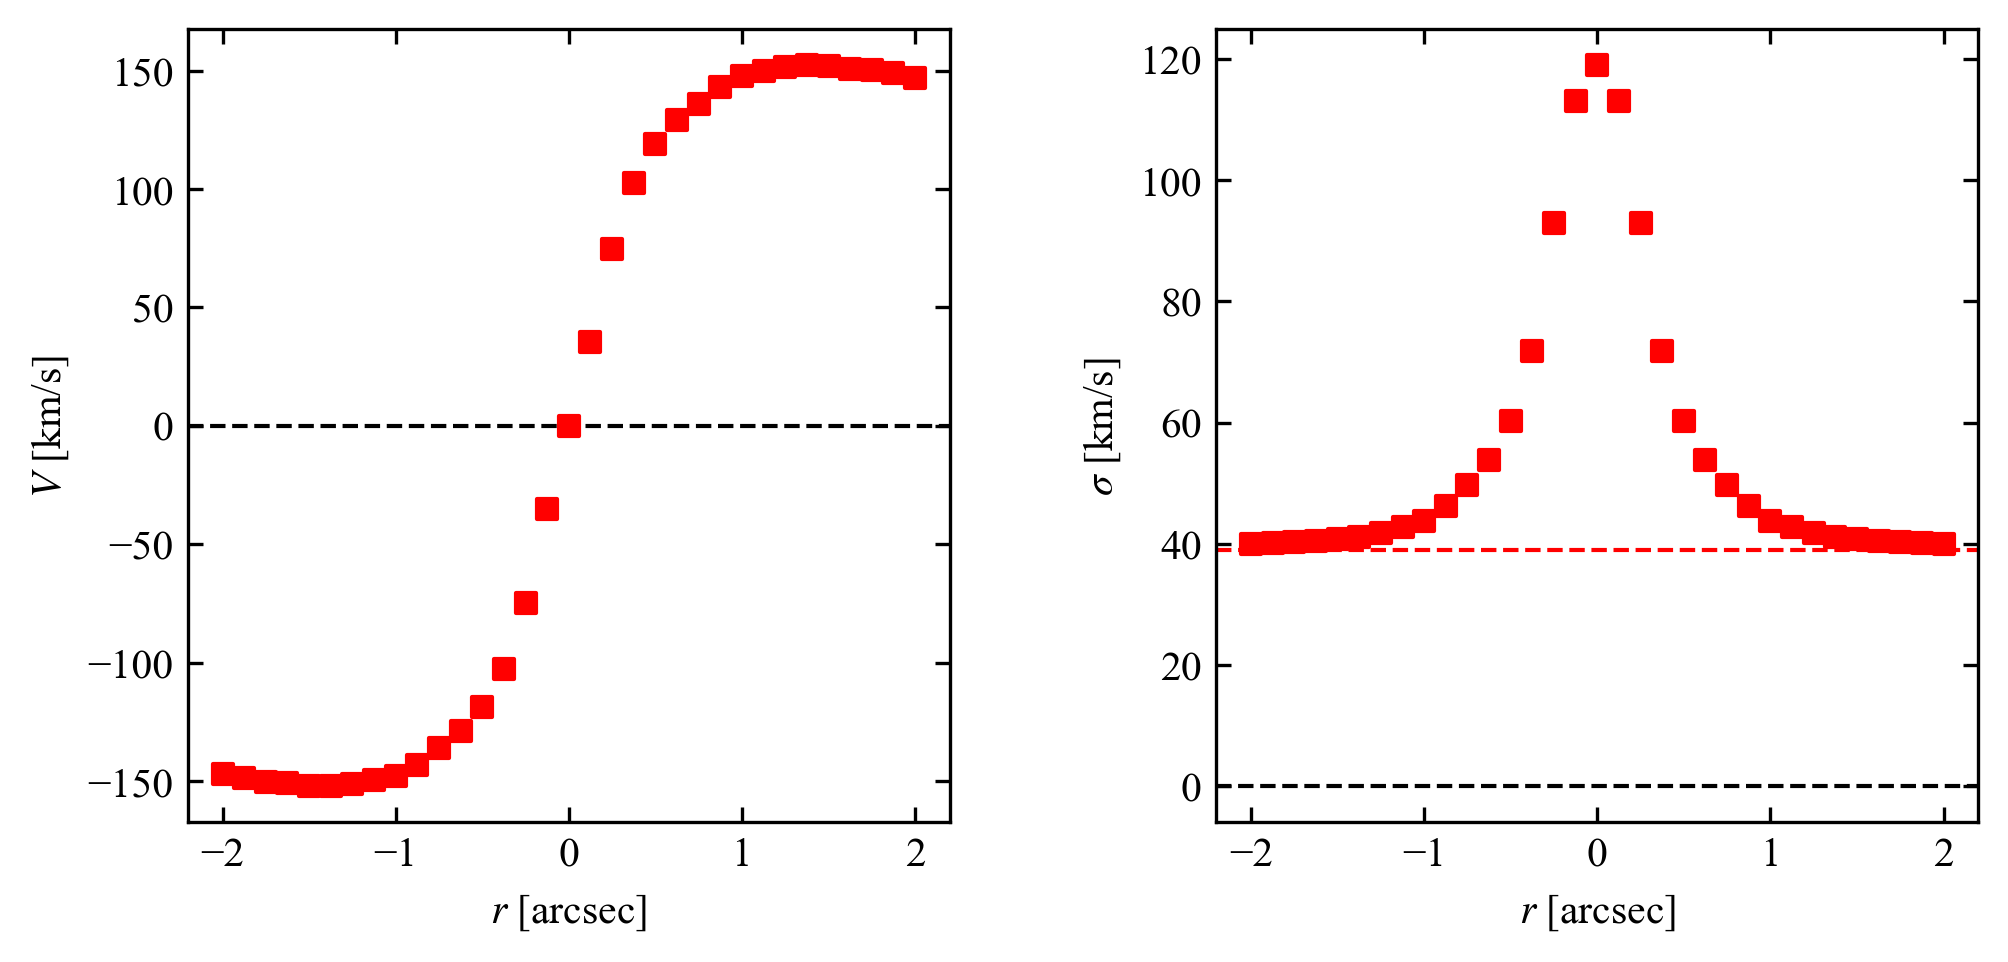

In [18]:
plotting.plot_model_1D(gal, inst_corr=True, best_dispersion=sigma0)